In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import Aer, AerSimulator

# from qiskit.extensions.quantum_initializer.initializer import Initialize
import matplotlib.pyplot as plt
import random
import math


# control is control qubit, target is the list of target qubit
def fanout(qc, control, target):
    length = len(target)
    d = math.ceil(math.log2(length))
    qc_temp = []
    for i in range(d):
        for j in range(length):
            if (2 * j + 1) <= length - 1:
                qc.cx(target[2 * j], target[2 * j + 1])
                qc_temp.append([target[2 * j], target[2 * j + 1]])
            else:
                break
        target = target[::2]
        length = len(target)
    qc.cx(control, target[0])
    for i in range(len(qc_temp)):
        a = qc_temp[len(qc_temp) - 1 - i][0]
        b = qc_temp[len(qc_temp) - 1 - i][1]
        qc.cx(a, b)


# inl is the list of input qubit, inl[0] dicide the sign of fixed point number, outl is the list of output qubit
def ReLU_c(qc, inl, outl):
    n = len(inl)
    qc.x(inl[0])
    for i in range(n - 1):
        qc.h(outl[i])
    for i in range(n - 1):
        qc.cx(inl[i + 1], outl[i])
    for i in range(n - 1):
        qc.tdg(outl[i])
    fanout(qc, inl[0], outl)  # first fanout
    for i in range(n - 1):
        qc.t(outl[i])
    for i in range(n - 1):
        qc.cx(inl[i + 1], outl[i])
    for i in range(n - 1):
        qc.tdg(outl[i])
    fanout(qc, inl[0], outl)  # second fanout
    for i in range(n - 1):
        qc.t(outl[i])
        qc.t(inl[i + 1])
    temp = (n - 1) % 8
    if temp == 1:
        qc.t(inl[0])
    elif temp == 2:
        qc.s(inl[0])
    elif temp == 3:
        qc.t(inl[0])
        qc.s(inl[0])
    elif temp == 4:
        qc.z(inl[0])
    elif temp == 5:
        qc.t(inl[0])
        qc.z(inl[0])
    elif temp == 6:
        qc.s(inl[0])
        qc.z(inl[0])
    elif temp == 7:
        qc.tdg(inl[0])
    # qc.barrier()               #this line can be deleted
    for i in range(n - 1):
        qc.h(outl[i])
    fanout(qc, inl[0], inl[1:n])  # third fanout
    for i in range(n - 1):
        qc.tdg(inl[i + 1])
    fanout(qc, inl[0], inl[1:n])  # last fanout
    qc.x(inl[0])


def ReLU(input_n, measure, initial):
    n = input_n - 1
    qc = QuantumCircuit(2 * n + 1, 2 * n + 1)
    inl = []
    outl = []
    inl.append(0)
    initial_state = []
    seed = "01"
    initial_state.append(random.choice(seed)[0])
    for i in range(n):
        inl.append(2 * i + 1)
        outl.append(2 * i + 2)
        initial_state.append(random.choice(seed)[0])
        initial_state.append("0")
    initial_state.reverse()
    initial_state = "".join(initial_state)
    print("initial state:", initial_state)
    # if initial == 1:
    #     qc.append(Initialize(initial_state), range(2*n+1))
    if initial == 1:
        for i in range(2 * n + 1):
            if initial_state[2 * n - i] == "1":
                qc.x(i)
    ReLU_c(qc, inl, outl)
    if measure == 1:
        qc.barrier()
        for i in range(2 * n + 1):
            qc.measure(i, i)
    return qc

initial state: 000100010100010


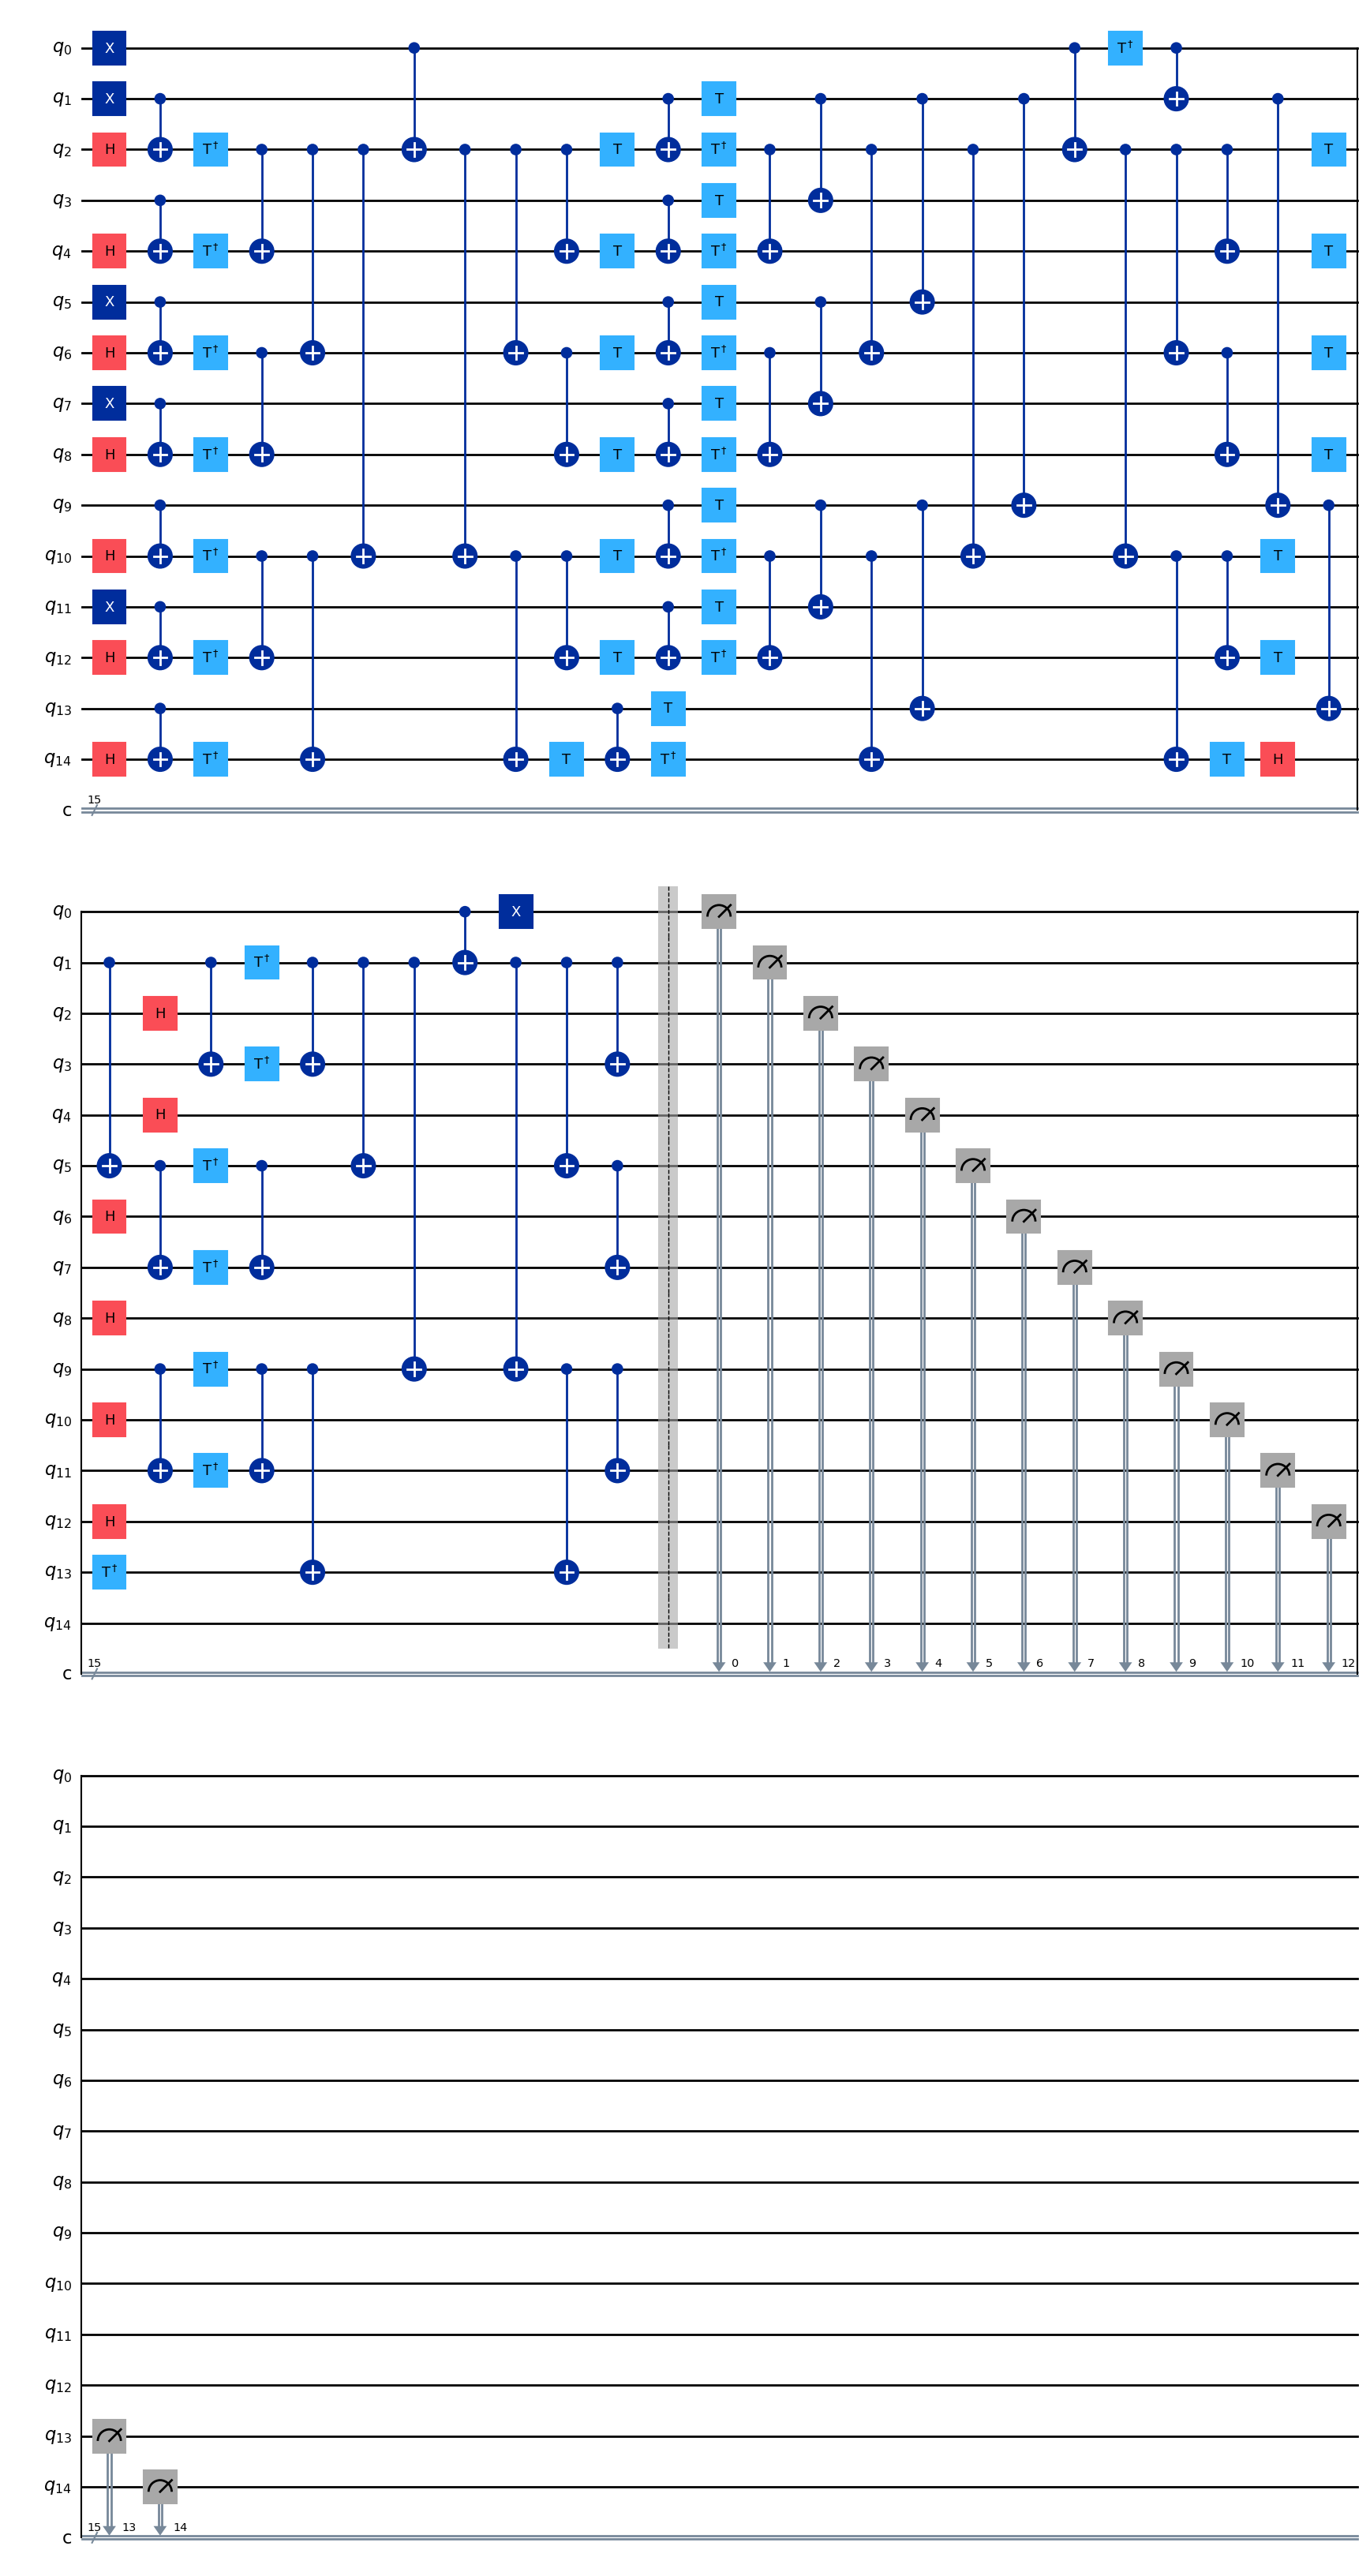

In [7]:
n = 8
qc = ReLU(n, 1, 1)
qc.draw("mpl")

# simulator = AerSimulator()
# compiled_circuit = transpile(qc, simulator)
# result = simulator.run(compiled_circuit).result()
# counts = result.get_counts()
# memory = result.get_memory(qc)
# check = 1
# for i in range(3):
#     inputc = []
#     outputc = []
#     inputc.append(memory[i][2 * n - 2])
#     for j in range(n - 1):
#         inputc.append(memory[i][2 * n - 2 - 2 * j - 1])
#         outputc.append(memory[i][2 * n - 2 - 2 * j - 2])
#     print("input[", i, "]", inputc)
#     print("output[", i, "]", outputc)
#     for j in range(n - 1):
#         if outputc[j] != inputc[j + 1]:
#             check = 0
# if check == 1:
#     print("Check Pass")